# Creando un Modelo de SVR para Prediccion de Consumo de Electricidad

En esta Parte de la Libreta vamos a crear un modelo de SVM ajustando hyperparametros usando RandomSearchCV y GridSearch

In [5]:
!pip install mlflow

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/25.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/25.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/25.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/25.0 MB 660.6 kB/s eta 0:00:38
   ---------------------------------------- 0.1/25.0 MB 544.7 kB/s eta 0:00:46
   ---------------------------------------- 0.1/25.0 MB 573.4 kB/s eta 0:00:44
   ---------------------------------------- 0.1/25.0 MB 595.3 kB/s eta 0:00:42
   ---------------------------------------- 0.2/25.0 MB 701.4 kB/s eta 0:00:36
   ---------------------------------------- 0.2/25.0 MB 701.4 kB/s eta 0:00:36
   ---------------------------------------- 0.2/25.0 MB 692.4 kB/s eta 0:00:36
   ---------------------------------------- 0.2/25.0 MB 752.5 kB/s eta 0:00:33
   ---------------------------------------- 0.3/25.0 MB 770.1 kB/s eta 0:00:33
    --

In [11]:
!pip install python-dotenv

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [1]:
import numpy as np
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import learning_curve, LearningCurveDisplay

Comenzando cargando nuestros datos procesados, para después pasarlos por la función `series_to_supervised` y así poderlos alimentar a nuestro modelo.

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
   """
   Frame a time series as a supervised learning dataset.
   Arguments:
   data: Sequence of observations as a list or NumPy array.
   n_in: Number of lag observations as input (X).
   n_out: Number of observations as output (y).
   """
   df = pd.DataFrame(data)
   col_names = df.columns
   cols, names = list(), list()
   # input sequence (t-n, ... t-1)
   for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [(f'{col}(t-{i})') for col in col_names]
   # forecast sequence (t, t+1, ... t+n)
   for i in range(0, n_out):
      cols.append(df.shift(-i))
   if i == 0:
      names += [(f'{col}(t)') for col in col_names]
   else:
      names += [(f'{col}(t+{i})') for col in col_names]
   # put it all together
   agg = pd.concat(cols, axis=1)
   agg.columns = names
   # drop rows with NaN values
   if dropnan:
      agg.dropna(inplace=True)
   return agg

### Cargando variables de entorno

MLflow ofrece un seguimiento detallado de métricas, hiperparámetros y versiones de modelos, lo que mejora la trazabilidad y la transparencia en el desarrollo de modelos. Además, su integración con diferentes frameworks de machine learning y su capacidad para realizar un seguimiento del ciclo de vida completo de un modelo, desde el entrenamiento hasta la implementación, lo convierten en una herramienta indispensable para garantizar la reproducibilidad, la colaboración y la gestión eficiente de los modelos en producción.

In [3]:
import requests
from getpass import getpass
import datetime

In [4]:
EXPERIMENT_NAME = "Modelo SVM" #@param {type:"string"}

In [5]:
!pip install mlflow --quiet

import mlflow
import os
from getpass import getpass

In [6]:
os.environ['MLFLOW_TRACKING_USERNAME'] = 'IvanDavila'
os.environ['MLFLOW_TRACKING_PASSWORD'] = getpass('Enter your DAGsHub access token or password: ')

mlflow.set_tracking_uri(f'https://dagshub.com/AAA-Energia/energy-demand-prediction.mlflow')
experiment = mlflow.set_experiment(EXPERIMENT_NAME)

In [7]:
data = pd.read_csv('../data/processed/processed_data_energy.csv')

In [8]:
data.head()

,hora,dia,mes,anio,tmax-cab,tmax-hmo,tmax-obr,tmax-lmo,tmax-cul,tmin-cab,...,martes_postfestivo,semana_santa,1_mayo,10_mayo,16_sep,2_nov.,pre-navidad_y_new_year,navidad_y_new_year,post-navidad_y_new_year,demanda_energia
0,0,1,1,2007,21.0,22.0,25.0,30.0,29.0,2.0,...,0,0,0,0,0,0,0,1,0,1394
1,1,1,1,2007,21.0,22.0,25.0,30.0,29.0,2.0,...,0,0,0,0,0,0,0,1,0,1297
2,2,1,1,2007,21.0,22.0,25.0,30.0,29.0,2.0,...,0,0,0,0,0,0,0,1,0,1255
3,3,1,1,2007,21.0,22.0,25.0,30.0,29.0,2.0,...,0,0,0,0,0,0,0,1,0,1222
4,4,1,1,2007,21.0,22.0,25.0,30.0,29.0,2.0,...,0,0,0,0,0,0,0,1,0,1168


In [9]:
data.columns

Index(['hora', 'dia', 'mes', 'anio', 'tmax-cab', 'tmax-hmo', 'tmax-obr',
       'tmax-lmo', 'tmax-cul', 'tmin-cab', 'tmin-hmo', 'tmin-obr', 'tmin-lmo',
       'tmin-cul', 'prec_hmo_mm', 'prec_obr_mm', 'prec_lmo_mm', 'prec_cul_mm',
       'lunes_festivo', 'martes_postfestivo', 'semana_santa', '1_mayo',
       '10_mayo', '16_sep', '2_nov.', 'pre-navidad_y_new_year',
       'navidad_y_new_year', 'post-navidad_y_new_year', 'demanda_energia'],
      dtype='object')

Embebemos las columnas provenientes de la fecha en un mismo dato datetime. Cambiamos los nombres de anio, mes, dia y hora a year, month, day, hour; esto nos facilita el trabajo de embeber estos datos a una variable datetime, con la función de pandas to_datetime(), ya que esta función toma estos nombres para incoporarlos. Posteriormente, eliminamos estas columnas.

In [10]:
data.rename(columns={"anio": "year", "mes": "month", "dia": "day", "hora": "hour"}, inplace=True)
data["datetime"] = pd.to_datetime(data[["year", "month", "day", "hour"]])

#borramos los valores que ya fueron embebidos en datetime
# data.drop(["year", "month", "day", "hour"], axis=1, inplace=True)

data.set_index("datetime", inplace=True)

La variables de clima se dan por razon de dia, asi por lo que se repiten a lo largo del transucrso de las horas; vamos a eliminar los dator repetidos y quedarnos con un dato por dia; hacemos esto haciend un remuestreo de los datos por dia tomando el promedio de los datos de todo un dia; como los datos son los mismos por dia el promedio sera igual a los valores.

In [11]:
df_mean = data.resample("1D").mean()

In [12]:
supervised_data = series_to_supervised(df_mean[df_mean.columns[4:]], n_in=12, n_out=1)

In [13]:
supervised_data.shape

(5599, 325)

In [14]:
# supervised_data["datetime"] = supervised_data.index

In [14]:
supervised_data.head()

,tmax-cab(t-12),tmax-hmo(t-12),tmax-obr(t-12),tmax-lmo(t-12),tmax-cul(t-12),tmin-cab(t-12),tmin-hmo(t-12),tmin-obr(t-12),tmin-lmo(t-12),tmin-cul(t-12),...,martes_postfestivo(t),semana_santa(t),1_mayo(t),10_mayo(t),16_sep(t),2_nov.(t),pre-navidad_y_new_year(t),navidad_y_new_year(t),post-navidad_y_new_year(t),demanda_energia(t)
datetime,,,,,,,,,,,,,,,,,,,,,
2007-01-13,21.0,22.0,25.0,30.0,29.0,2.0,9.0,8.0,10.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1437.041667
2007-01-14,21.0,22.0,22.0,22.0,27.0,2.0,7.0,7.0,11.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1348.375000
2007-01-15,22.0,22.0,23.0,25.0,27.0,6.0,6.0,10.0,11.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1452.375000
2007-01-16,22.0,24.0,26.0,26.0,28.0,5.0,11.0,9.0,11.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1503.083333
2007-01-17,24.0,21.0,25.0,28.0,29.0,6.0,10.0,9.0,10.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1505.125000


In [15]:
X = supervised_data.drop(columns=['demanda_energia(t)'])
y = pd.DataFrame(supervised_data['demanda_energia(t)'])

In [17]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
X_train = X[:"2019"]
y_train = y[:"2019"]
X_test = X["2020":]
y_test = y["2020":]

In [17]:
X_train.head()

,tmax-cab(t-12),tmax-hmo(t-12),tmax-obr(t-12),tmax-lmo(t-12),tmax-cul(t-12),tmin-cab(t-12),tmin-hmo(t-12),tmin-obr(t-12),tmin-lmo(t-12),tmin-cul(t-12),...,lunes_festivo(t),martes_postfestivo(t),semana_santa(t),1_mayo(t),10_mayo(t),16_sep(t),2_nov.(t),pre-navidad_y_new_year(t),navidad_y_new_year(t),post-navidad_y_new_year(t)
datetime,,,,,,,,,,,,,,,,,,,,,
2007-01-13,21.0,22.0,25.0,30.0,29.0,2.0,9.0,8.0,10.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-01-14,21.0,22.0,22.0,22.0,27.0,2.0,7.0,7.0,11.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-01-15,22.0,22.0,23.0,25.0,27.0,6.0,6.0,10.0,11.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-01-16,22.0,24.0,26.0,26.0,28.0,5.0,11.0,9.0,11.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-01-17,24.0,21.0,25.0,28.0,29.0,6.0,10.0,9.0,10.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X_train)

In [19]:
svr_model = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)

In [20]:
train_sizes, train_scores, test_scores = learning_curve(svr_model, X_scaled, y_train)

c:\Users\Ivan\.conda\envs\machin\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Ivan\.conda\envs\machin\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Ivan\.conda\envs\machin\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Ivan\.conda\envs\machin\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

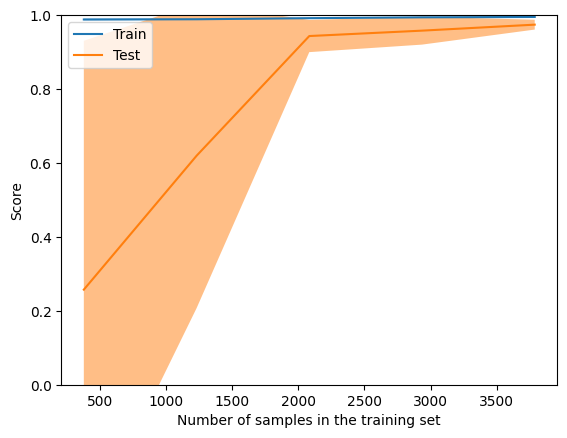

In [21]:
display = LearningCurveDisplay(train_sizes=train_sizes,
    train_scores=train_scores, test_scores=test_scores, score_name="Score")
display.plot()
plt.ylim([0,1])
plt.show()

In [22]:
mlflow.sklearn.autolog()

In [23]:
svr_model.fit(X_scaled, y_train)

2024/05/26 15:17:03 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5ad3745ef7ca46aca9b2aa516a78a082', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/05/26 15:17:03 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'flatten'
c:\Users\Ivan\.conda\envs\machin\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
2024/05/26 15:17:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\Ivan\.conda\envs\machin\lib\site-packages\_distutils_hack\__init__.py:26: UserWarning: Setuptools is replacing distutils."


SVR(C=100, coef0=1, gamma='auto', kernel='poly')

In [24]:
y_predict = svr_model.predict(X_scaled)

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [26]:
mse = mean_squared_error(y_train, y_predict)
print(f"El error cuadrado medio tiene un valor de {mse:.2f}")

El error cuadrado medio tiene un valor de 2301.92


In [27]:
mape = mean_absolute_percentage_error(y_train, y_predict)
print(f"El MAPE tiene un valor de {mape:.2f}")

El MAPE tiene un valor de 0.01


In [28]:
y_predict_df = pd.DataFrame(y_predict)
y_predict_df.set_index(y_train.index, inplace=True)

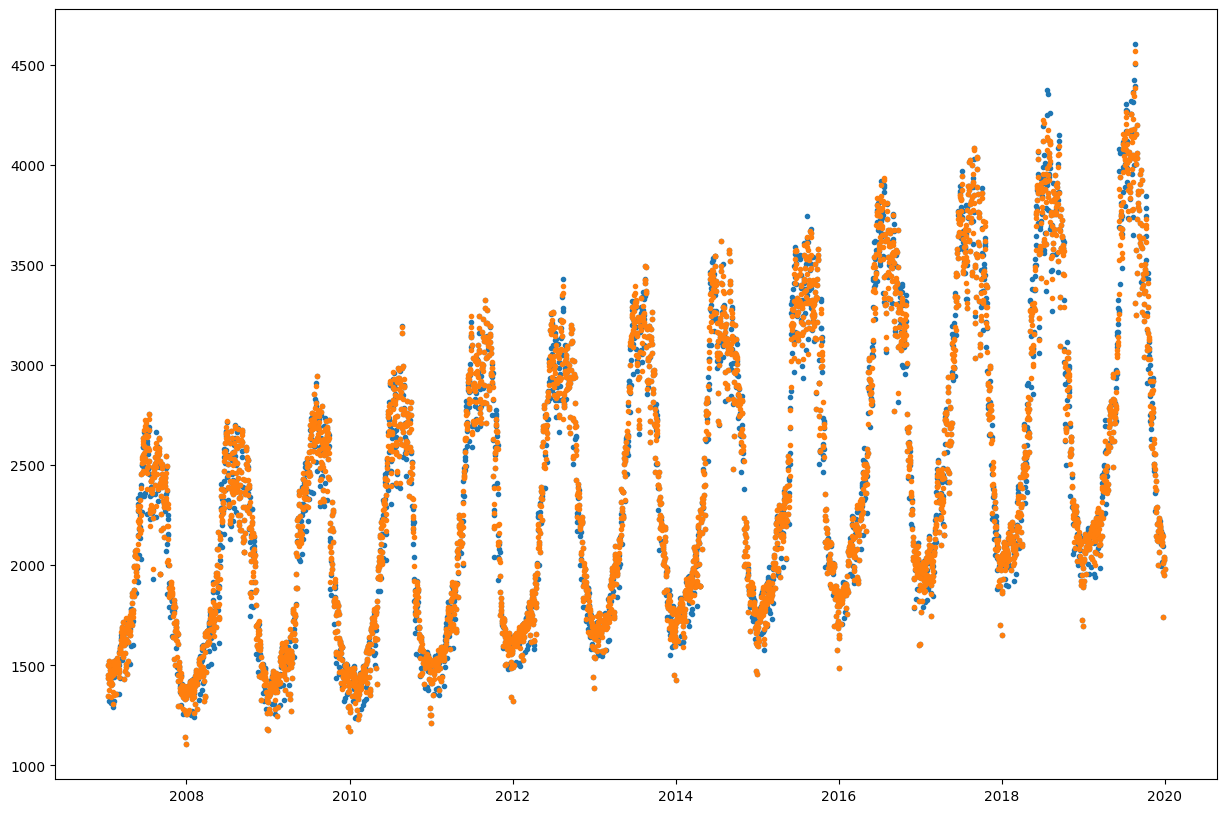

In [29]:
fig, axes = plt.subplots(figsize=(15, 10), sharey=True)
axes.plot(y_train, ".")
axes.plot(y_predict_df, ".")

In [30]:
X_test_scaled = scaler_x.transform(X_test)

In [31]:
y_test_predict = svr_model.predict(X_test_scaled)

In [32]:
mse = mean_squared_error(y_test, y_test_predict)
print(f"El error cuadrado medio tiene un valor de {mse:.2f}")

El error cuadrado medio tiene un valor de 6476.32


In [33]:
mape = mean_absolute_percentage_error(y_test, y_test_predict)
print(f"El MAPE tiene un valor de {mape:.2f}")

El MAPE tiene un valor de 0.02


In [34]:
y_predict_test_df = pd.DataFrame(y_test_predict)
y_predict_test_df.set_index(y_test.index, inplace=True)

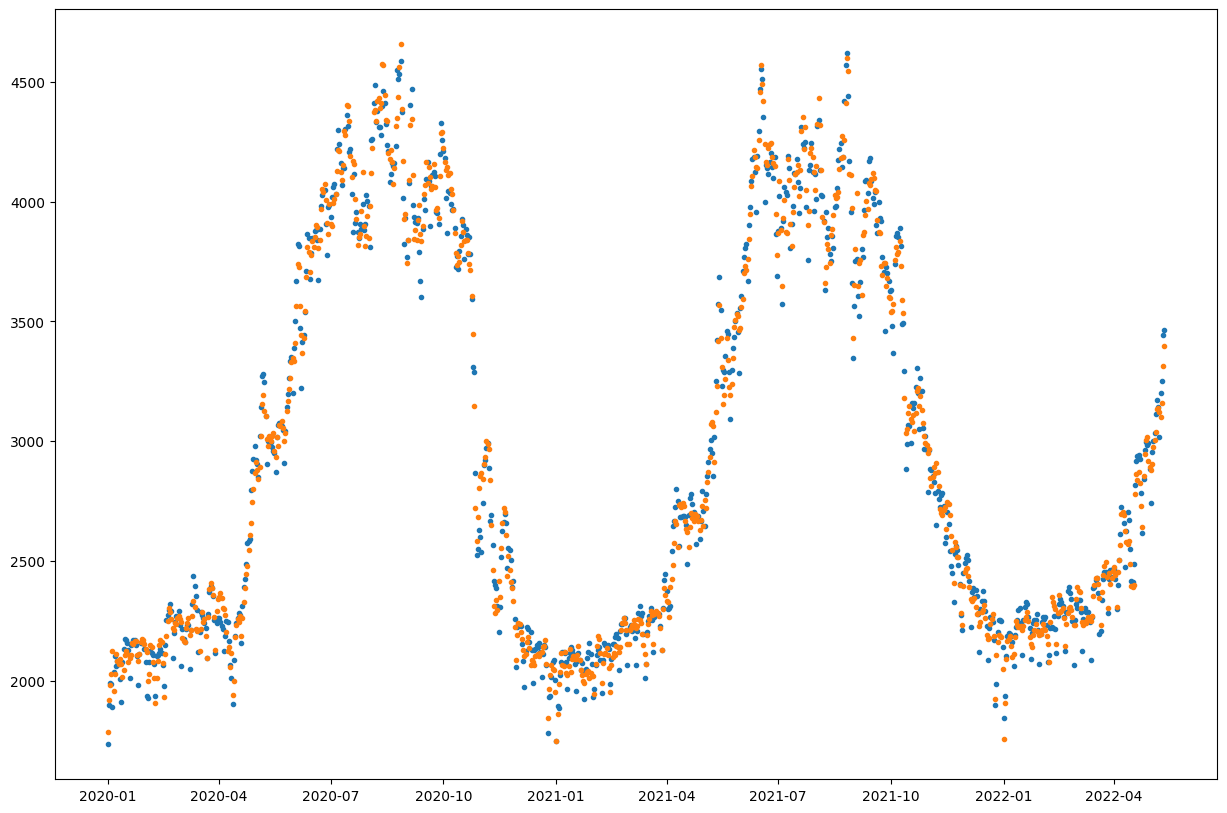

In [35]:
fig, axes = plt.subplots(figsize=(15, 10), sharey=True)
axes.plot(y_test, ".")
axes.plot(y_predict_test_df, ".")

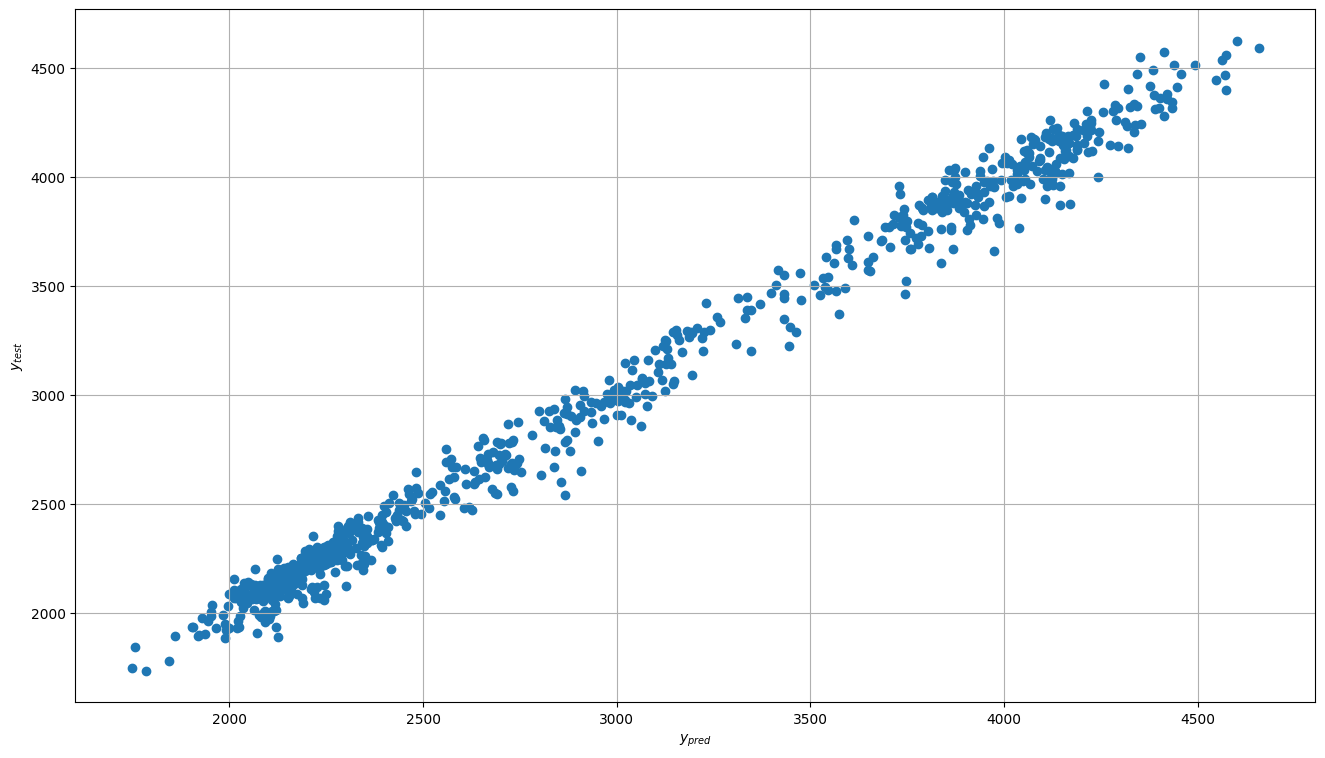

In [36]:
fig,ax = plt.subplots(figsize=(16,9))
ax.grid()
ax.scatter(y_predict_test_df, y_test)
ax.set_ylabel(r'$y_{test}$')
ax.set_xlabel(r'$y_{pred}$')
plt.show()

### Usando Randomized Search

Queremos usar RandomizedSearchCV de sklearn para poder llegar a la mejor de las soluciones.

In [37]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

In [56]:
# Create a scorer to use (use the mean squared error)
scorer = make_scorer(mean_squared_error)
svr = SVR()
param_dist={
    "kernel" : ["poly"],
    "degree" : [3],
    "gamma" : ["auto"],
    "coef0" : [1],
    "C": [100], 
    "epsilon": [0.001, 0.01, 0.1]
    }

random_search = RandomizedSearchCV(
    svr,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    random_state=47,
    scoring=scorer
)

In [57]:
random_search.fit(X_scaled, y_train)

2024/05/26 15:44:26 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '345c283207c04264b54ec59e8420ccc0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/05/26 15:44:26 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'flatten'
c:\Users\Ivan\.conda\envs\machin\lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\Ivan\.conda\envs\machin\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Ivan\.conda\envs\machin\lib\site-packages\sklearn\

RandomizedSearchCV(cv=5, estimator=SVR(),
                   param_distributions={'C': [100], 'coef0': [1], 'degree': [3],
                                        'epsilon': [0.001, 0.01, 0.1],
                                        'gamma': ['auto'], 'kernel': ['poly']},
                   random_state=47,
                   scoring=make_scorer(mean_squared_error, response_method='predict'))

Despues de 15 minutos de busqueda se encontraron los mejores parametros:

In [40]:
print(f"Los Mejores parametros para SVR son: {random_search.best_params_} and R2 score: {random_search.best_score_:.3f}")

Best SVR with params: {'kernel': 'poly', 'gamma': 'auto', 'epsilon': 0.001, 'degree': 3, 'coef0': 1, 'C': 1} and R2 score: 157876.280


In [41]:
y_predict = random_search.predict(X_scaled)

In [42]:
mse = mean_squared_error(y_train, y_predict)
print(f"El error cuadrado medio tiene un valor de {mse:.2f}")

El error cuadrado medio tiene un valor de 74502.85


In [43]:
mape = mean_absolute_percentage_error(y_train, y_predict)
print(f"El MAPE tiene un valor de {mape:.2f}")

El MAPE tiene un valor de 0.09


In [44]:
y_predict_df = pd.DataFrame(y_predict)
y_predict_df.set_index(y_train.index, inplace=True)

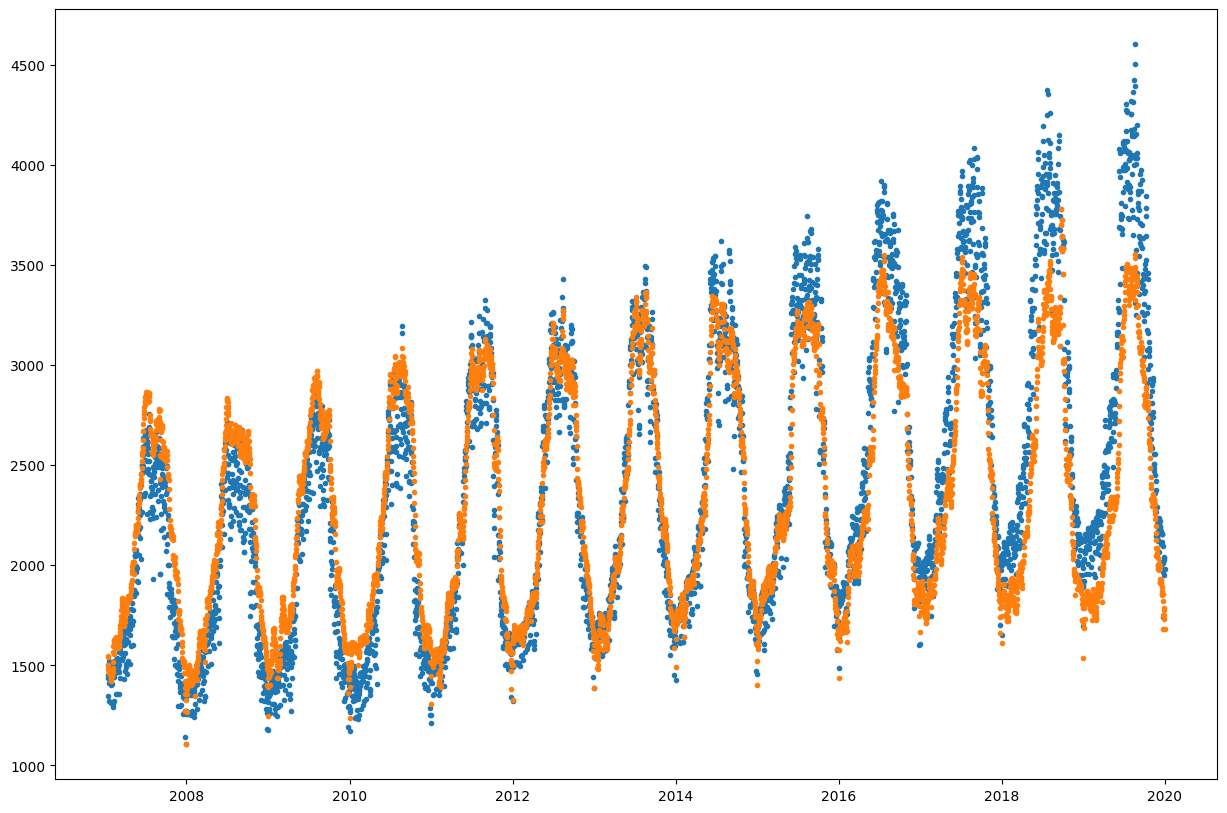

In [45]:
fig, axes = plt.subplots(figsize=(15, 10), sharey=True)
axes.plot(y_train, ".")
axes.plot(y_predict_df, ".")

In [46]:
y_predict_test_randm = random_search.predict(X_test_scaled)

In [47]:
mse = mean_squared_error(y_test, y_predict_test_randm)
print(f"El error cuadrado medio tiene un valor de {mse:.2f}")

El error cuadrado medio tiene un valor de 259926.40


In [48]:
mape = mean_absolute_percentage_error(y_test, y_predict_test_randm)
print(f"El MAPE tiene un valor de {mape:.2f}")

El MAPE tiene un valor de 0.16


## Tunneando Hyperparametros con GridSearch

Ddao que RandomSearch no dio un resultado favorable, usamos GridSearch para encontrar los parametos que mejor ajustan a nuestros resultados. 

In [49]:
from sklearn.model_selection import GridSearchCV

In [50]:
# Create a scorer to use (use the mean squared error)
scorer = make_scorer(mean_squared_error)
svr = SVR(kernel="poly", gamma="auto", degree=3, coef0=1)
param_dist={"C": [1, 10, 100, 1000], "epsilon": [0.001, 0.01, 0.1]}

gridsearch = GridSearchCV(
    svr,
    param_grid=param_dist,
    scoring=scorer
)

In [51]:
gridsearch.fit(X_scaled, y_train)

2024/05/26 15:30:32 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7caba7c6d853464e9a082073da992638', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/05/26 15:30:32 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'flatten'
c:\Users\Ivan\.conda\envs\machin\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Ivan\.conda\envs\machin\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Ivan\.conda\envs\mach

GridSearchCV(estimator=SVR(coef0=1, gamma='auto', kernel='poly'),
             param_grid={'C': [1, 10, 100, 1000],
                         'epsilon': [0.001, 0.01, 0.1]},
             scoring=make_scorer(mean_squared_error, response_method='predict'))

In [52]:
print(f"Best SVR with params: {gridsearch.best_params_} and R2 score: {gridsearch.best_score_:.3f}")

Best SVR with params: {'C': 1, 'epsilon': 0.001} and R2 score: 157876.280


In [53]:
y_predict = gridsearch.predict(X_scaled)

In [54]:
y_predict_grids = gridsearch.predict(X_scaled)

mse = mean_squared_error(y_train, y_predict_grids)
mape = mean_absolute_percentage_error(y_train, y_predict_grids)

print(f"El error cuadrado medio tiene un valor de {mse:.2f}")
print(f"El MAPE tiene un valor de {mape:.2f}")

El error cuadrado medio tiene un valor de 74502.85
El MAPE tiene un valor de 0.09


In [55]:
mlflow.end_run(status='FINISHED')

## Conclusion

En nuestra libreta, nos vimos obligados a condensar los datos a días debido a la falta de convergencia en la solución utilizando el método de Vectores de Soporte, lo que resultaba en iteraciones infinitas. A pesar de emplear GridSearch y RandomSearchCV, no logramos obtener un resultado superior al de la solución de prueba. Se insta a investigar en el futuro para comprender por qué la búsqueda de hiperparámetros no arrojó mejores resultados.